# Analysis of 103k entries from the WOS

State of OA dataset

**Results are not 100% correct (some FB engagement numbers are missing) as some errors occured in the data collection**

Will be eventually updated if we run the fixed script again for this data.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from pprint import pprint

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})

plt.rcParams["figure.figsize"] = (9,5)

from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

In [10]:
full_df = pd.read_csv("PKP_temp.csv", encoding = 'utf8')
df_dates = pd.read_csv("data/input_files/PKP_20171220.csv", encoding = 'utf8')
full_df = full_df.merge(df_dates, on="doi").set_index("doi")
full_df['date'] = pd.to_datetime(full_df.date)
full_df['year'] = full_df.date.apply(lambda x: x.year)

# Table of Contents

## Bad rows (DOI resolve errors, URL-OG mapping errors)

ATM 25k rows are removed because of:

+ Remove bad urls (if resolved URL appears more than once in the results -> removed)
+ Remove entries with DOI resolve errors
+ Remove all entries with identical OG IDs
+ Exclude papers before 2008 and after 2015


## Some stats

**Frequencies**

Few stats for number of found articles across platform, years, and OA status

+ [Frequencies across years](#Frequencies-across-years)

**Shares**

Stats for the average number of shares across platform , years, and OA status.
Median numbers not included as they are quite boring (lots of 0 shares for FB, lots of 1 shares for Altmetric)

+ [Average shares across years](#Average-shares-across-years)

**Correlations**

+ [Correlation](#Correlation)

# Bad rows

In [30]:
print("The Bad Boyz\n")

# DOI resolving errors

resolve_errors = full_df[full_df.doi_resolve_status != "200"]
pprint(resolve_errors.doi_url.value_counts())
print("")

# Bad OG object mapping DOI -> URL -> OG

a = full_df.fb_og_id.value_counts().keys()[full_df.fb_og_id.value_counts() > 1][1:]
tdf = full_df[[x in a for x in full_df.fb_og_id]][["doi_url", "fb_og_id", "fb_share_count", "am_share_count"]]
pprint(tdf.describe().loc['count'])

# Export the "bad" DOIs as CSV files
# resolve_errors[['doi', 'url']].to_csv("recrawl_doi.csv", index=False)
# tdf[['doi', 'url']].to_csv("bad_urls.csv", index=False)

The Bad Boyz

None    52571
Name: doi_url, dtype: int64

fb_og_id          3477.0
fb_share_count    3477.0
am_share_count     514.0
Name: count, dtype: float64


Clean df and remove bad results :

In [58]:
bad_resolves = list(full_df.doi_resolve_status != "200")

bad_urls = list(full_df.doi_url.value_counts().keys()[full_df.doi_url.value_counts() > 1])
bad_url_papers = [x in bad_urls for x in full_df.doi_url]

bad_og_id = list(full_df.fb_og_id.value_counts().keys()[full_df.fb_og_id.value_counts() > 1])[1:]
bad_og_papers = [x in bad_og_id for x in full_df.fb_og_id]

min_year = 1997
max_year = 2017
too_early = [x < min_year for x in full_df.year]
too_late = [x > max_year for x in full_df.year]

bad_papers = list(np.any([bad_resolves, bad_url_papers, too_late, too_early, bad_og_papers], 0))

df = full_df[[not _ for _ in bad_papers]]

print("Bad URLs: {}".format(sum(bad_url_papers)))
print("Bad OG IDs: {}".format(sum(bad_og_papers)))
print("Bad DOI resolves: {}".format(sum(bad_resolves)))
# print("Paper <2008: {}".format(sum(too_early)))
# print("Paper >2015: {}".format(sum(too_late)))

print("Total removed papers: {}".format(sum(bad_papers)))

Bad URLs: 61640
Bad OG IDs: 3477
Bad DOI resolves: 52571
Total removed papers: 75073


## Preprocessing

Replace NaNs with 0.0 if either altmetric response or OG object was found, but on shares

In [60]:
# Transformed dataframe for year/oa_color_long/platform plotting
pdf = df[['year', 'am_share_count', 'fb_share_count']].melt(id_vars = ['year'], var_name="platform", value_name="shares")
df[['year', 'am_share_count', 'fb_share_count']];

## Frequencies across years

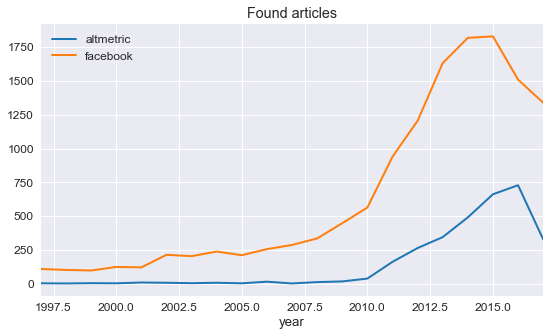

In [61]:
df.groupby(['year'])[['am_share_count', 'fb_share_count']].count().plot();
# plt.xlim([min_year, max_year]);
plt.gca().legend(labels=["altmetric", "facebook"]);
plt.title("Found articles");

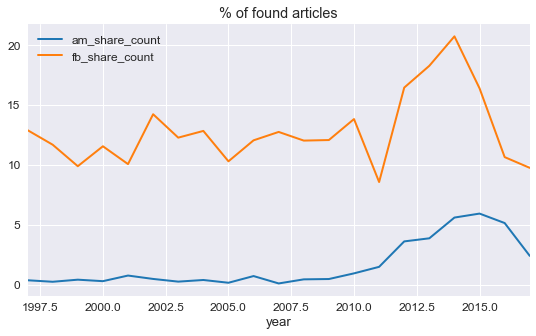

In [62]:
a = df.groupby(['year']).count()
(100*a[['am_share_count', 'fb_share_count']].divide(a.date,0)).plot();
plt.title("% of found articles");

## Average shares across years

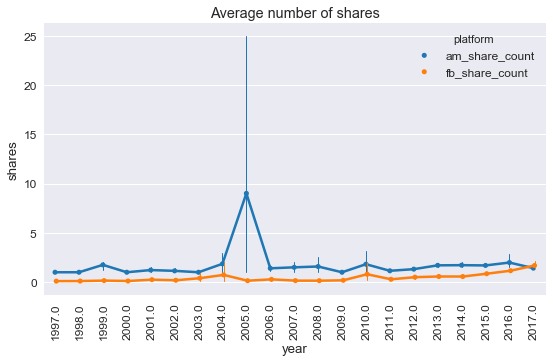

In [88]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");
plt.xticks(rotation=90);

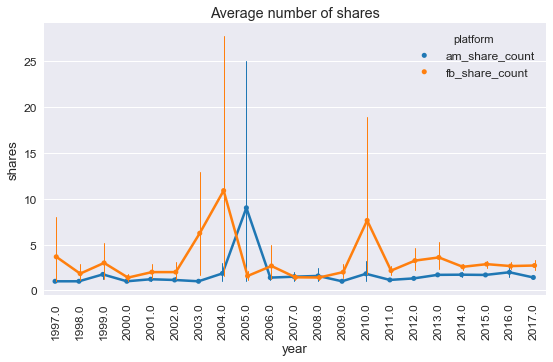

In [89]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf[pdf.shares != 0],
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares with rows dropped ");
plt.xticks(rotation=90);

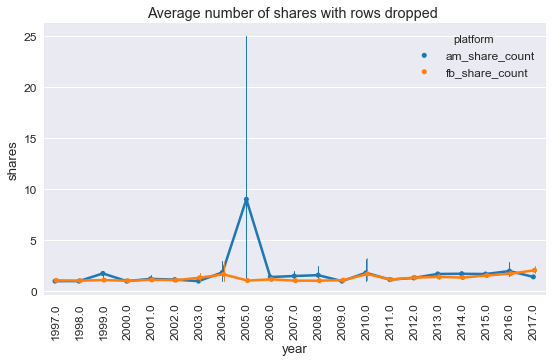

In [99]:
temp = pdf
temp.loc[pdf['shares'] == 0, 'shares'] = 1
sns.pointplot(x="year", y="shares", hue="platform", data=temp,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares with rows dropped ");
plt.xticks(rotation=90);

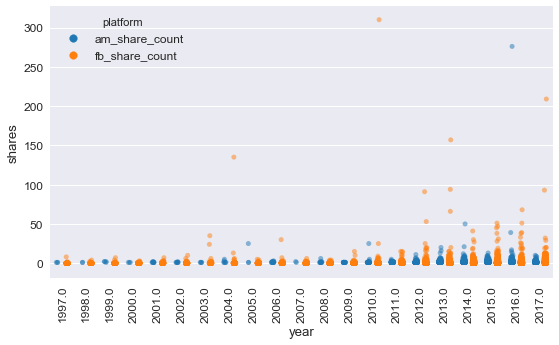

In [70]:
sns.stripplot(x="year", y="shares", hue="platform", data=pdf, jitter=True, dodge=True, alpha=.5);
plt.xticks(rotation=90);

## Correlation

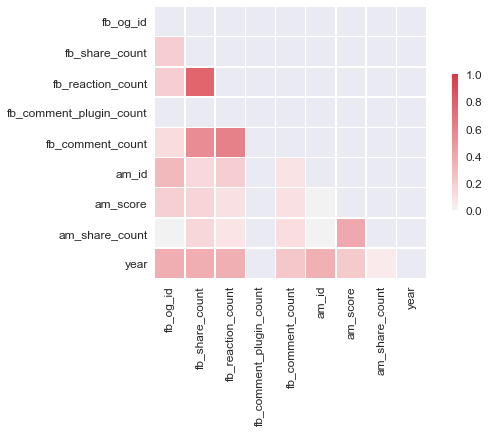

In [54]:
corr = df.corr(method = "spearman")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})